(1)forecast a univariate time series
(2)multivariate time series.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
14개의 기온, 기압, 습도 등의 기후 데이터를 포함하고 있으며 2003년부터 매 10분마다 적재되었음. 
- 09~16년도 만

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 15)

*매 10분마다 측정해서 1시간에 6개의 observation이 있으며 하루에 144개의 데이터가 있음 

*특정시점에서 6시간뒤의 온도를 예측하는 모형을 생성 
  5일간의 데이터를 사용-> 144*5 = 720개의 데이터를 사용하여 학습. 

*'history_size'는 과거의 정보 'target_size'는 얼마나 먼 미래를 예측하고 싶은지 우리가 원하는예측값의 사이즈 


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

*학습데이터: 300,000 rows(~2100일) 나머지는 확인 데이터. 


In [7]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [8]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
*self데이터만을 사용해서 예측. 

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5F08A2DC8>],
      dtype=object)

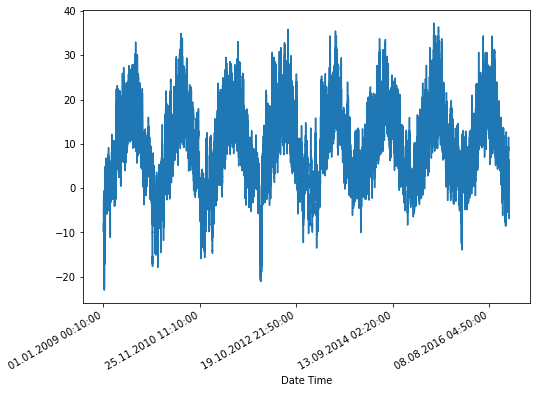

In [10]:
uni_data.plot(subplots=True)

**스캐일링하는것은 매우 중요. Standardization은 mean값을 뺸 뒤 std으로 내누는 방식을 택함 (가장 보편적) `tf.keras.utils.normalize`을 사용해서 [0,1]사이의 값으로 스케일링 .

Note: The mean and standard deviation should only be computed using the training data.

In [11]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [12]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [13]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [14]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


*데이터가 생성완료 
하나의 예시 (주어진 정보는 blue, red 의 정보를 예측해야함)

In [15]:
def create_time_steps(length):
    return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yckim\\Anaconda3\\envs\\TS_sample2\\lib\\site-packages\\matplotlib\\pyplot.py'>

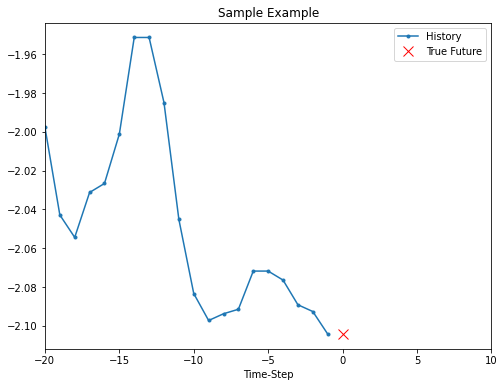

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
베이스라인 --> 과거 20개의 observation의 평균을 예측값으로 설정 


In [18]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\yckim\\Anaconda3\\envs\\TS_sample2\\lib\\site-packages\\matplotlib\\pyplot.py'>

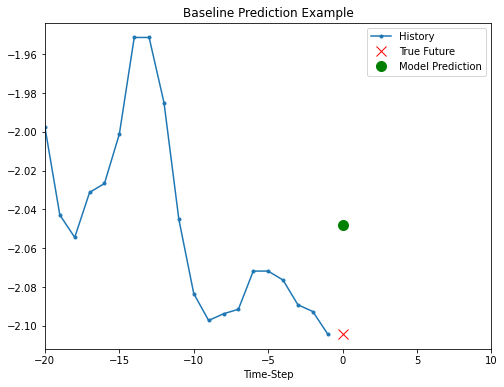

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network (LSTM)

`tf.data`를 통해 셔플링, 배치화 등을 할 수 있음 

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
print(train_univariate)
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
print(train_univariate)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
print(val_univariate)
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
print(val_univariate)

print("=====================")
print(x_train_uni.shape)
print("=====================")
print(x_train_uni.shape[-2:])

<TensorSliceDataset shapes: ((20, 1), ()), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((20, 1), ()), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
(299980, 20, 1)
(20, 1)


LSTM모형 정의

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]), # 뒤에서 2번째부터 끝까지
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


**학습 과정 --> 메모리/시간상 각 epoch에 200번의 step만 

In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 9s 46ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0253 - val_loss: 0.0181ETA: 0s - loss: 0.0
Epoch 10/10
200/200 [========

#### Predict using the simple LSTM model


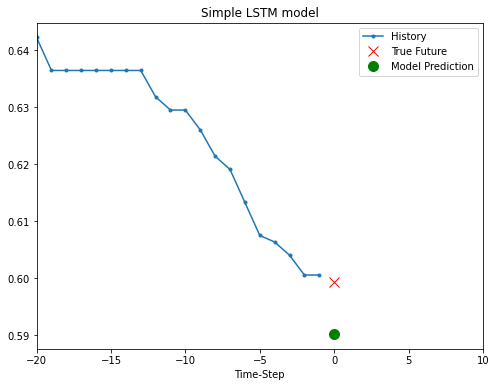

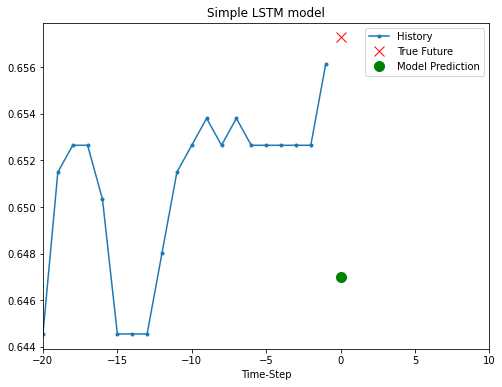

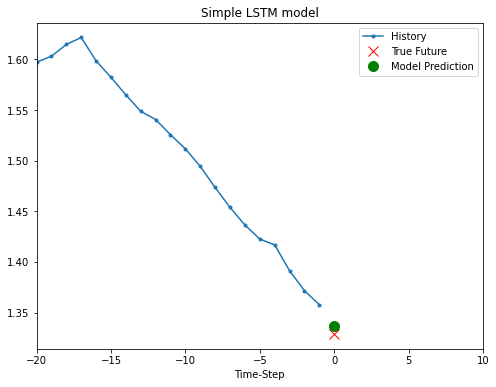

In [24]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Part 2: Forecast a multivariate time series

원 데이터에는 14개의 feature가 포함되어있으나 예쩨에서는 3개만 포함. (온도, 기압, air density)

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [26]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


각각의 feature의 raw data 확인 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D587B59D88>,
      dtype=object)

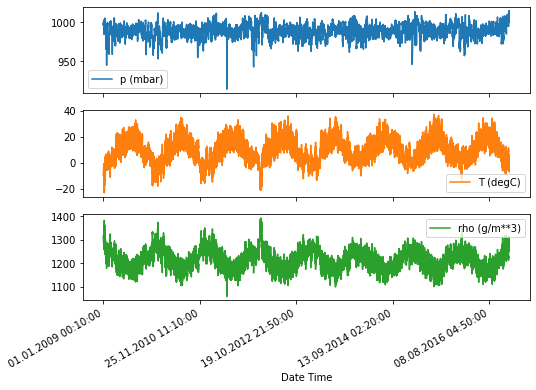

In [27]:
features.plot(subplots=True)

데이터에 처음 해야할 일은 언제나 Standardization!!

In [28]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [29]:
dataset = (dataset-data_mean)/data_std

In [30]:
dataset

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       ...,
       [ 1.35617678, -1.43494935,  1.76136375],
       [ 1.35496252, -1.55883897,  1.88786728],
       [ 1.35617678, -1.62715193,  1.95686921]])

In [31]:
dataset[:, 1]

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

### Single step model
Single Step에서는 과거를 통해 한개의 포인트를 예측 

위의 예제와 같은 윈도우를 취함. 

In [32]:
# univariate : 5개
# dataset, start_index, end_index, history_size, target_size
# multivariate : 8개
# dataset, target, start_index, end_index, history_size, target_size, step, single_step
# target, step, single_step 매개변수가 추가됨
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

- 네트워크는 지난 5일 (720개의 값) 의 데이터가 매 시간 측정됨. 1시간동안 큰 변화가 없다는 가정하에 시간당의 샘플링을 취함. 
- 따라서 지난 720개가 아닌 120개의 데이터가 지난 5일간의 과거를 표현. 
- Single Step Prediction a모형에서는 12시간 뒤의 데이터포인트였으나 이번에는 72개 뒤의 값을 책정 (12*6) 

In [33]:
past_history = 720
future_target = 72
STEP = 6


# multivariate : 8개
# dataset, target, start_index, end_index, history_size, target_size, step, single_step
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [34]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [35]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [36]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [37]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [38]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 52s 259ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 61s 305ms/step - loss: 0.2625 - val_loss: 0.2432
Epoch 3/10
200/200 [==============================] - 75s 376ms/step - loss: 0.2614 - val_loss: 0.2476
Epoch 4/10
200/200 [==============================] - 95s 474ms/step - loss: 0.2566 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 122s 608ms/step - loss: 0.2267 - val_loss: 0.2360
Epoch 6/10
200/200 [==============================] - 141s 704ms/step - loss: 0.2413 - val_loss: 0.2667
Epoch 7/10
200/200 [==============================] - 142s 710ms/step - loss: 0.2414 - val_loss: 0.2577
Epoch 8/10
200/200 [==============================] - 126s 629ms/step - loss: 0.2407 - val_loss: 0.2371
Epoch 9/10
200/200 [==============================] - 126s 630ms/step - loss: 0.2447 - val_loss: 0.2486
Epoch 10/10
200/200 [====

In [39]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

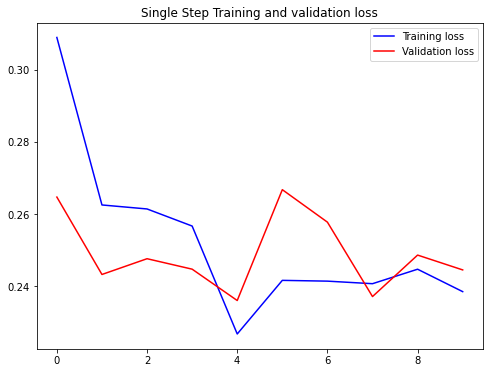

In [40]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

#### Predict a single step future
모형이 학습이되었으니 예측값을 생성해보자. 
3개의 feature의 5일간의 시간당 과거값을 사용 (120개의 데이터들)하여 온도값을 예측. 
예측값은 하루뒤의 값을 예측하도록 설정 

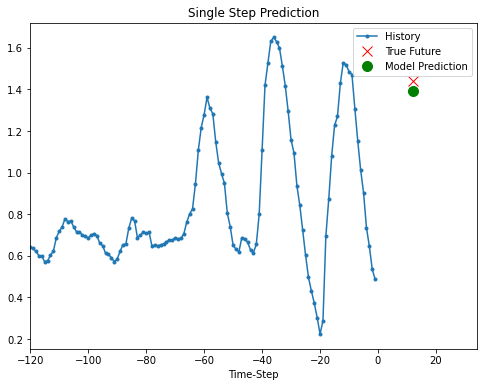

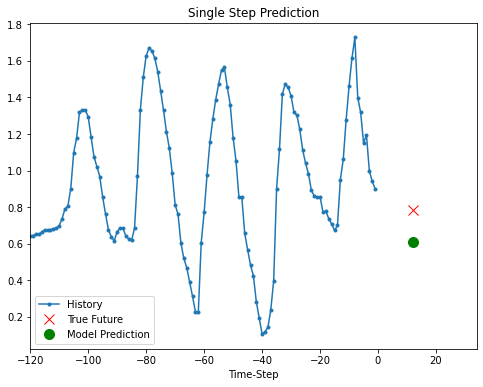

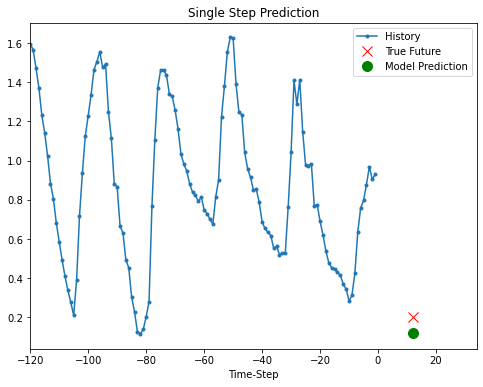

In [41]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'Single Step Prediction')
    plot.show()

### Multi-Step model
멀티스텝 모형에서는 과거가 주어졌을때 미래 값의 Range를 예측하도록 설정. (Sequence를 예측)

멀티스텝모형에서 역시 학습 데이터는 과거 5일간의 시간당 샘플된 데이터를 사용. 이 모형에서는 다음 12시간동안의 온도를 예측 (매 10분마다 측정된 값이므로 72개의 예측값을 뱉어내야 함) 


In [42]:
# 인풋 매개변수로 7개가 들어감. target history를 72로 설정한다는 것
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [43]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [44]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [45]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')

    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
  
    plt.legend(loc='upper left')
    plt.show()



```
# This is formatted as code
```

플랏을 그릴때는 과거와 미래값은 시간당 데이터로 표현

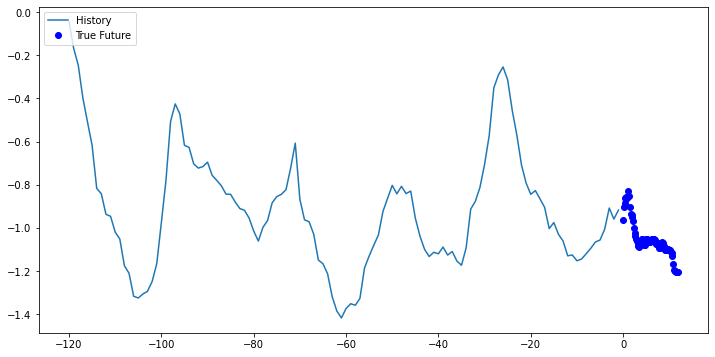

In [46]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

조금 더 복잡한 모형이라 두개의 LSTM레이어를 쌓도록 함. 
Dense Layer는 72개의 아웃풋을 생성 

In [47]:
## Seq2Seq 모델의 형태로 접근
# 마지막 Fully-Connected 설정을 72개
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [48]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [49]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 184s 921ms/step - loss: 0.4974 - val_loss: 0.3019
Epoch 2/10
200/200 [==============================] - 253s 1s/step - loss: 0.3480 - val_loss: 0.2845
Epoch 3/10
200/200 [==============================] - 224s 1s/step - loss: 0.3335 - val_loss: 0.2523
Epoch 4/10
200/200 [==============================] - 261s 1s/step - loss: 0.2438 - val_loss: 0.2093
Epoch 5/10
200/200 [==============================] - 284s 1s/step - loss: 0.1962 - val_loss: 0.2025
Epoch 6/10
200/200 [==============================] - 307s 2s/step - loss: 0.2062 - val_loss: 0.2108
Epoch 7/10
200/200 [==============================] - 285s 1s/step - loss: 0.1981 - val_loss: 0.2047
Epoch 8/10
200/200 [==============================] - 283s 1s/step - loss: 0.1965 - val_loss: 0.1983
Epoch 9/10
200/200 [==============================] - 273s 1s/step - loss: 0.2001 - val_loss: 0.1873
Epoch 10/10
200/200 [========================

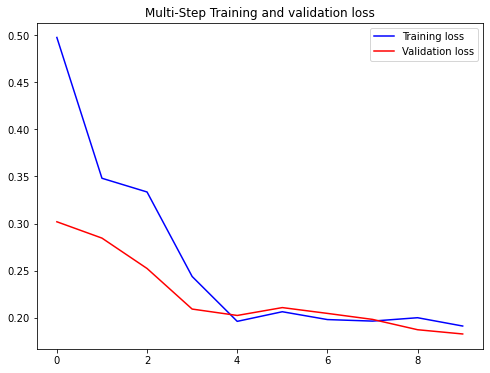

In [50]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

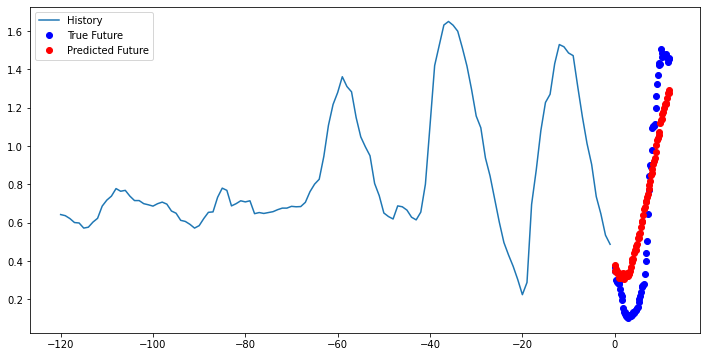

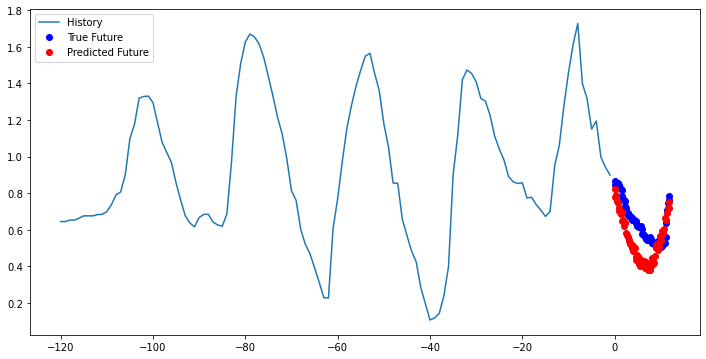

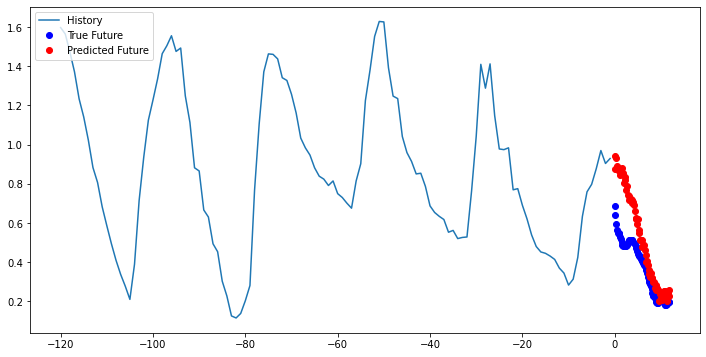

In [51]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])